In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import logging, pickle
logging.basicConfig(filename='./_logs/exp-1-simulation-analysis.log',level=logging.DEBUG)
from itertools import product
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pyrlap.domains.gridworld import GridWorld
from demoteaching.mdps.discretizedobmdp import DiscretizedObserverBeliefMDPApproximation

In [3]:
def calc_trajectory_stats(tblock):
    #time on uncertain colors versus certain colors
    uncertain_col = 0
    certain_col = 0
    unknown_color_freq = {'o': 0, 'p': 0, 'c': 0}
    revisits = {}
    traj = []
    for _, step in tblock.iterrows():
        if gw.is_terminal(step['s']):
            continue
        traj.append((step['s'], step['a']))
        s = step['s']
        revisits[s] = revisits.get(s, -1)
        revisits[s] += 1
        fs = set(gw.get_state_features(step['s']))
        ufs = {'o', 'p', 'c'}.intersection(fs)
        if len(ufs) > 0:
            uncertain_col += 1
            unknown_color_freq[ufs.pop()] += 1
        else:
            certain_col += 1
            
    #entropy of frequency distribution over unknown color-tile visits
    counts = list(unknown_color_freq.values())
    props = np.array([c/sum(counts) for c in counts])
    props = props[props > 0]
    ent = -np.sum(props*np.log2(props))
    
    # simpson's diversity index: \sum_{i}n_i (n_i - 1) / (N_i(N_i - 1)) [Simpson, 1949]
    simpdiv = 1 - sum([n*(n-1) for n in counts if n > 0])/(sum(counts)*(sum(counts) - 1))

    #demonstration length
    dem_len = len(tblock)

    #revisitation
    avg_revisit = np.mean(list(revisits.values()))
    tot_revisit = np.sum(list(revisits.values()))
    
    #final first order belief
    btarg = tblock.iloc[-1]['b_target']
    
    #final second order belief
    b2targ = tblock.iloc[-1]['b2_target']
    
    #final second order joint belief
    b2jtarg = tblock.iloc[-1]['b2j_target']
    
    #marginalized correct probabilities
    true_rf = tblock.iloc[0]['mdp_code']
    fstep = tblock.iloc[-1]
    def calc_correct(b, color):
        return b if true_rf[{'orange':0, 'purple':1, 'blue':2}[color]] == 'o' else (1-b)
    
    b_orange = calc_correct(fstep['b.ooo'] + fstep['b.oox'] + fstep['b.oxo'] + fstep['b.oxx'], 'orange')
    b_purple = calc_correct(fstep['b.ooo'] + fstep['b.oox'] + fstep['b.xoo'] + fstep['b.xox'], 'purple')
    b_blue = calc_correct(fstep['b.ooo'] + fstep['b.oxo'] + fstep['b.xoo'] + fstep['b.xxo'], 'blue')
    b2_orange = calc_correct(fstep['b2.ooo'] + fstep['b2.oox'] + fstep['b2.oxo'] + fstep['b2.oxx'], 'orange')
    b2_purple = calc_correct(fstep['b2.ooo'] + fstep['b2.oox'] + fstep['b2.xoo'] + fstep['b2.xox'], 'purple')
    b2_blue = calc_correct(fstep['b2.ooo'] + fstep['b2.oxo'] + fstep['b2.xoo'] + fstep['b2.xxo'], 'blue')
    b2j_orange = calc_correct(fstep['b2j.ooo_com'] + fstep['b2j.oox_com'] + fstep['b2j.oxo_com'] + fstep['b2j.oxx_com'] + \
        fstep['b2j.ooo_nocom'] + fstep['b2j.oox_nocom'] + fstep['b2j.oxo_nocom'] + fstep['b2j.oxx_nocom'], 'orange')
    b2j_purple = calc_correct(fstep['b2j.ooo_com'] + fstep['b2j.oox_com'] + fstep['b2j.xoo_com'] + fstep['b2j.xox_com'] + \
        fstep['b2j.ooo_nocom'] + fstep['b2j.oox_nocom'] + fstep['b2j.xoo_nocom'] + fstep['b2j.xox_nocom'], 'purple')
    b2j_blue = calc_correct(fstep['b2j.ooo_com'] + fstep['b2j.oxo_com'] + fstep['b2j.xoo_com'] + fstep['b2j.xxo_com'] + \
        fstep['b2j.ooo_nocom'] + fstep['b2j.oxo_nocom'] + fstep['b2j.xoo_nocom'] + fstep['b2j.xxo_nocom'], 'blue')
    
    #is this person communicating?
    mdp_codes = ['ooo', 'oox', 'oxo', 'oxx', 'xoo', 'xox', 'xxo', 'xxx' ]
    b2j_com = sum([fstep['b2j.{}_com'.format(rf)] for rf in mdp_codes])
    
    return pd.Series({
        'traj': tuple(traj),
        'uncertain_prop': uncertain_col/(uncertain_col+certain_col),
        'unknown_color_ent': ent,
        'unknown_color_div': simpdiv,
        "dem_len": dem_len,
        "avg_revisit": avg_revisit,
        'n_revisit': tot_revisit,
        'final_btarg': btarg,
        'final_b2targ': b2targ,
        'final_b2jtarg': b2jtarg,
        'b_orange_cor': b_orange,
        'b_purple_cor': b_purple,
        'b_blue_cor': b_blue,
        'b2_orange_cor': b2_orange,
        'b2_purple_cor': b2_purple,
        'b2_blue_cor': b2_blue,
        'b2j_orange_cor': b2j_orange,
        'b2j_purple_cor': b2j_purple,
        'b2j_blue_cor': b2j_blue,
        'b2j_com': b2j_com
    })

In [4]:
goal_s = (5, 2)
init_ground = (0, 2)

params = {
    'gridworld_array': ['.oooo.',
                        '.oppp.',
                        '.opccy',
                        '.oppc.',
                        '.cccc.'],
    'feature_rewards': {'y': 10},
    'absorbing_states': [goal_s, ],
    'init_state': init_ground,
    'wall_action': False,
    'step_cost': 0,
    'wait_action': False,
    'include_intermediate_terminal': True
}
gw = GridWorld(**params)

# Analyze effect of experimental trajectories on beliefs

In [5]:
exp_trials_sim_obs = pd.read_pickle("./_comps/exp-trajs-sim-obs.df.pkl")
exp_trials_sim_obs = exp_trials_sim_obs[exp_trials_sim_obs['phase'] == 'demonstration']
exp_traj_stats = exp_trials_sim_obs.groupby(['cond', 'mdp_code', 'participant']).apply(calc_trajectory_stats)
exp_traj_stats = exp_traj_stats.reset_index()

In [6]:
exp_traj_stats.groupby(['cond'])[[
    'final_btarg', 'final_b2targ', 'final_b2jtarg', 'b2j_com']].agg(['mean', 'sem'])

final_btarg           final_b2targ           final_b2jtarg            \
            mean       sem         mean       sem          mean       sem   
cond                                                                        
do      0.424722  0.017464     0.482054  0.032826      0.428261  0.019916   
show    0.617755  0.022071     0.712708  0.029187      0.653642  0.022501   

       b2j_com            
          mean       sem  
cond                      
do    0.208904  0.013957  
show  0.301691  0.020597

In [7]:
# Save experimental trajectories summary stats
exp_traj_stats[
    ['cond', 'mdp_code', 'participant',
     'final_btarg', 'final_b2targ', 'final_b2jtarg',
     'b2j_com']].\
    to_csv("./_comps/exp_traj_beliefs.csv")

## Behavioral analysis of experimental trajectories alone

In [7]:
%load_ext rpy2.ipython
import scipy
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri

from rpy2.robjects.conversion import localconverter

In [8]:
def sem(v):
    return np.sqrt(np.sum((v - np.mean(v))**2)/(len(v) - 1))

In [12]:
# mixed effects linear regression over color visitation entropy
lmerTest = importr('lmerTest')
with localconverter(ro.default_converter + pandas2ri.converter):
    model = lmerTest.lmer(
        f"unknown_color_ent ~ cond + (1 | mdp_code) + (1 | participant)",
        data=exp_traj_stats[['mdp_code', 'cond', 'participant', 'unknown_color_ent']],
        REML=False)
    ro.globalenv['model'] = model
    colnames = ro.r("colnames(summary(model)$coefficients)")
    rownames = ro.r("rownames(summary(model)$coefficients)")
    coefficients = []
    for rn in rownames:
        res = ro.r(f"summary(model)$coefficients['{rn}',]")
        res = dict(zip(colnames, res))
        res['fixed_effect'] = rn
        coefficients.append(res)
    coefficients = pd.DataFrame(coefficients)[['fixed_effect', ]+list(colnames)]
coefficients.index = coefficients['fixed_effect']
del coefficients['fixed_effect']
coefficients

,Estimate,Std. Error,df,t value,Pr(>|t|)
fixed_effect,,,,,
(Intercept),0.566593,0.161877,8.524745,3.500148,0.007312
condshow,0.155480,0.047064,57.042665,3.303610,0.001652


In [75]:
"\linregfixed{0.16}{0.05}{57.04}{3.30}{< .01}"

'\\linregfixed{0.16}{0.05}{57.04}{3.30}{< .01}'

In [71]:
# mixed effects logistic regression over color visitation
exp_trials = exp_trials_sim_obs[['a', 'cond', 'episode', 'mdp_code', 'ns', 'participant', 'r', 's', 't']].copy()
exp_trials['is_color'] = exp_trials.apply(lambda r: gw.state_features[r['s']] in 'opc', axis=1)

lme4 = importr('lme4')
with localconverter(ro.default_converter + pandas2ri.converter):
    model = lme4.glmer(
        f"is_color ~ cond + (1 | mdp_code) + (1 | participant)",
        data=exp_trials[['mdp_code', 'cond', 'participant', 'is_color']],
        family=ro.r('binomial(link="logit")'),
        REML=False)
    ro.globalenv['model'] = model
    colnames = ro.r("colnames(summary(model)$coefficients)")
    rownames = ro.r("rownames(summary(model)$coefficients)")
    coefficients = []
    for rn in rownames:
        res = ro.r(f"summary(model)$coefficients['{rn}',]")
        res = dict(zip(colnames, res))
        res['fixed_effect'] = rn
        coefficients.append(res)
    coefficients = pd.DataFrame(coefficients)[['fixed_effect', ]+list(colnames)]
coefficients.index = coefficients['fixed_effect']
del coefficients['fixed_effect']
coefficients

,Estimate,Std. Error,z value,Pr(>|z|)
fixed_effect,,,,
(Intercept),0.428062,0.131074,3.265793,0.001092
condshow,0.404039,0.099925,4.043426,0.000053


In [66]:
"\logregfixed{0.40}{0.10}{4.04}{< .0001}"

'\\logregfixed{0.40}{0.10}{4.04}{< .0001}'

## Plot experimental trajectories and their effects on beliefs

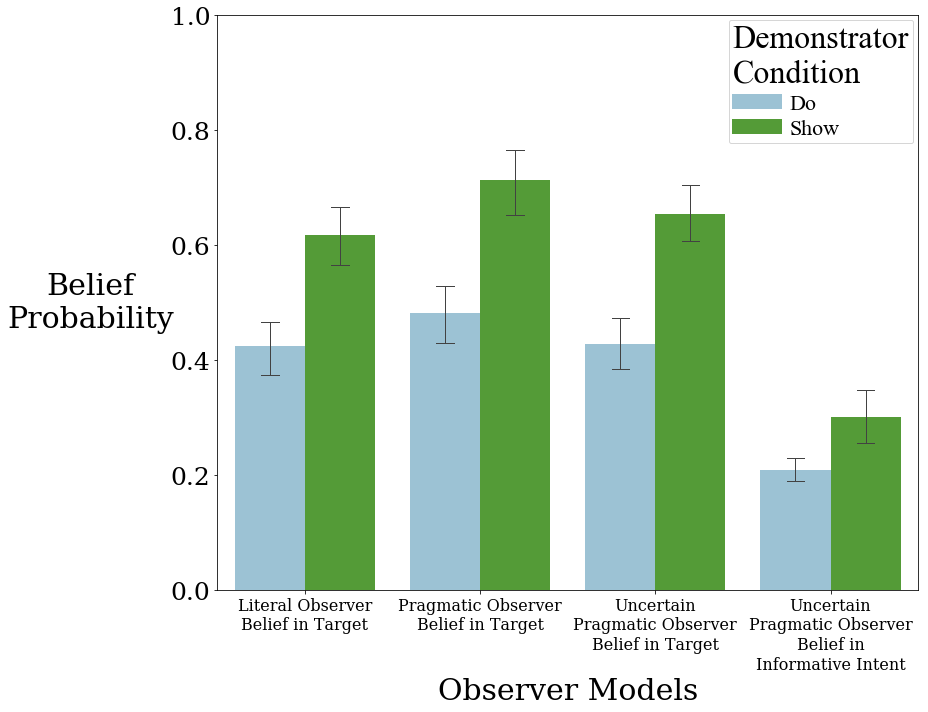

In [10]:
from matplotlib import rc
import matplotlib
# rc('text', usetex=True)
# plt.rc('font', family='serif')
# matplotlib.rcParams['pdf.fonttype'] = 42
# matplotlib.rcParams['ps.fonttype'] = 42

exp_mean_btarg = exp_traj_stats.groupby(['cond', 'participant'])[[
    'final_btarg', 'final_b2targ', 'final_b2jtarg','b2j_com']].mean().reset_index()
exp_mean_btarg = exp_mean_btarg.melt(
    id_vars=['participant', 'cond'],
    var_name='obs_type', value_name='belief')

fig, ax = plt.subplots(1, 1, figsize=(13, 10))
g = sns.barplot(
    ax=ax,
    data=exp_mean_btarg,
    x='obs_type',
    y='belief',
    hue='cond',
    errwidth=1,
    capsize=.1,
    ci=95,
    hue_order=['do', 'show'],
    palette=["#92C5DE", "#4DAC26"]
)
plt.ylim(0, 1)
plt.ylabel("Belief\nProbability", 
           fontsize=30, 
           fontname="Times New Roman", 
           rotation=0, 
           va='center', 
           labelpad=80,
           family='serif'
          )
plt.yticks(fontsize=25, 
           family='serif',
#            fontname="Times New Roman"
          )
g.set(xticklabels=['Literal Observer\nBelief in Target',
                   'Pragmatic Observer\nBelief in Target', 
                   'Uncertain\nPragmatic Observer\nBelief in Target',
                   'Uncertain\nPragmatic Observer\nBelief in\nInformative Intent'])
plt.xticks(fontsize=16, family='serif')
g.set_xlabel("Observer Models", 
             fontsize=30,
             family='serif')

ax.get_legend().get_title().set_text("Demonstrator\nCondition")
ax.get_legend().get_texts()[0].set_text("Do")
g.legend_.legendHandles[0].set(width=50, x=-50, height=15)
g.legend_.get_texts()[0].set(x=-20)
ax.get_legend().get_texts()[1].set_text("Show")
g.legend_.legendHandles[1].set(width=50, x=-50, height=15)
g.legend_.get_texts()[1].set(x=-20)

plt.setp(ax.get_legend().get_texts(), fontsize='22', fontname="Times New Roman", ma='left') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='32', fontname="Times New Roman") # for legend title
plt.tight_layout()

plt.savefig("./_figures/exp1-human-belief-plan-results.eps")

# Simulated Trials

In [13]:
#Trials generated by simulations of the model 
# and run on observer belief transition models
sim_trials = pd.read_pickle("./_comps/sim-trajs.df.pkl")

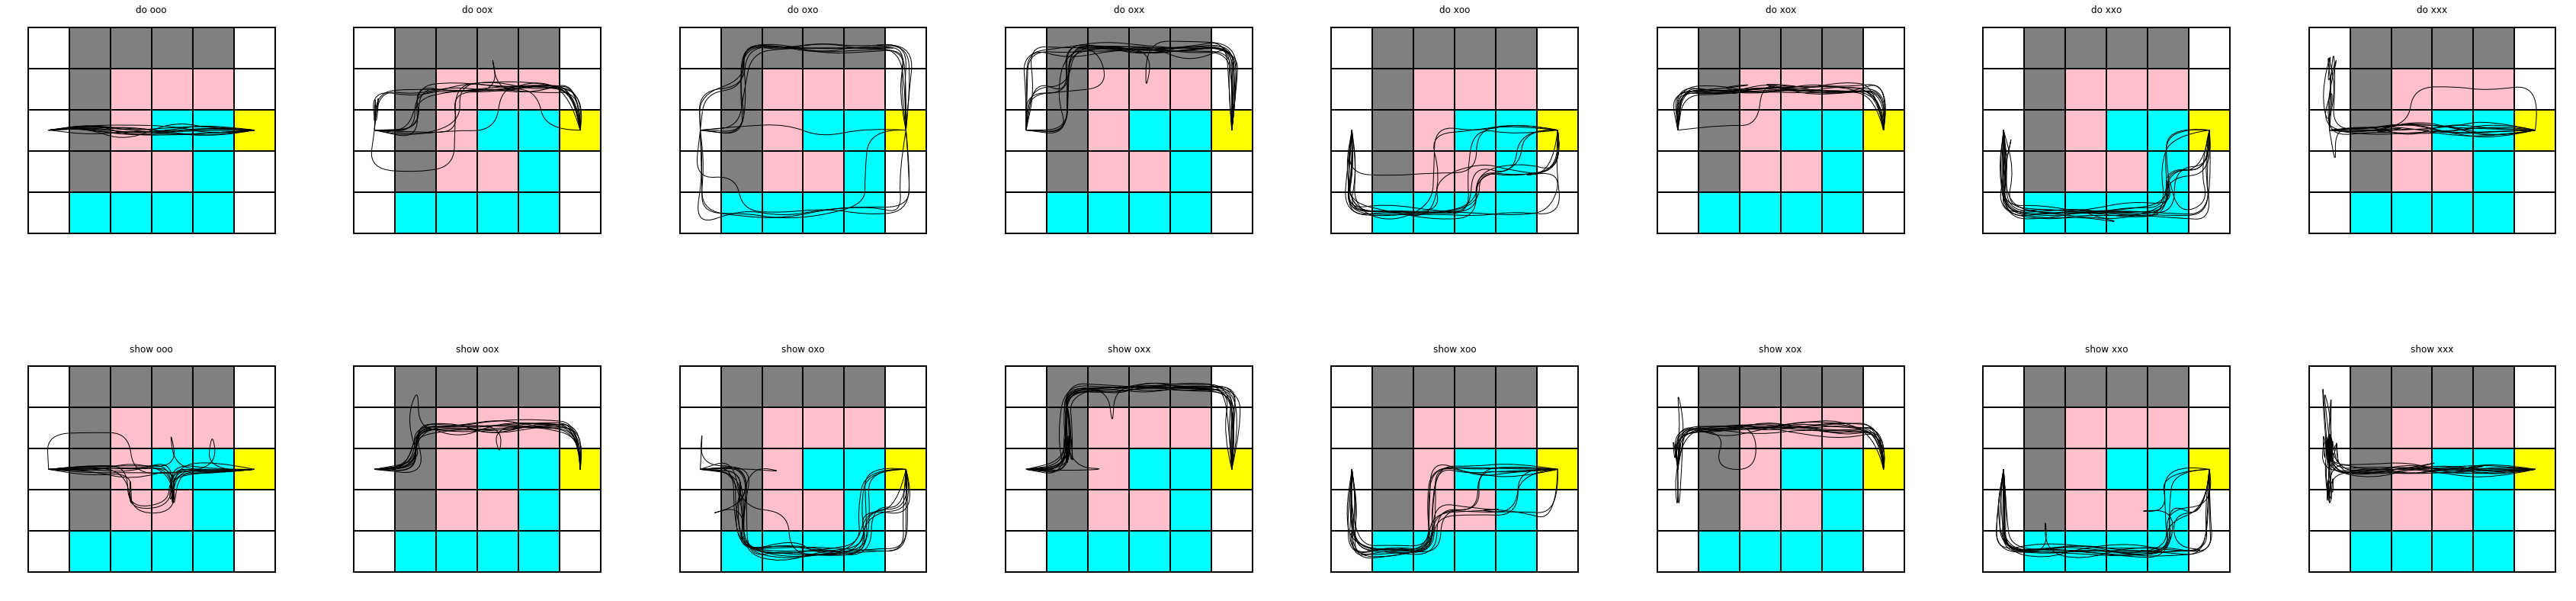

In [5]:
trajs = {}
fig, axes = plt.subplots(2, 8, figsize=(60, 15))
ax_i = 0

for mdpc, trajs in sim_trials[sim_trials['belief-reward'] == 0].groupby("mdp_code"):
    ax = axes[0][ax_i]
    ax_i += 1
    gwp = gw.plot(ax=ax)
    gwp.title("do "+mdpc)
    for ti, tblock in trajs.groupby("traj_i"):
        traj = list(zip(*tblock[["s", "a"]].apply(tuple)))
        gwp.plot_trajectory(traj[:-1])
        if ti > 10:
            break

ax_i = 0
for mdpc, trajs in sim_trials[sim_trials['belief-reward'] == 10].groupby("mdp_code"):
    ax = axes[1][ax_i]
    ax_i += 1
    gwp = gw.plot(ax=ax)
    gwp.title("show "+mdpc)
    for ti, tblock in trajs.groupby("traj_i"):
        traj = list(zip(*tblock[["s", "a"]].apply(tuple)))
        gwp.plot_trajectory(traj[:-1])
        if ti > 10:
            break

In [187]:
#this takes 2 mins
sim_traj_stats = sim_trials.groupby(["belief-reward", "mdp_code", "traj_i"]).apply(calc_trajectory_stats)
sim_traj_stats = sim_traj_stats.reset_index()

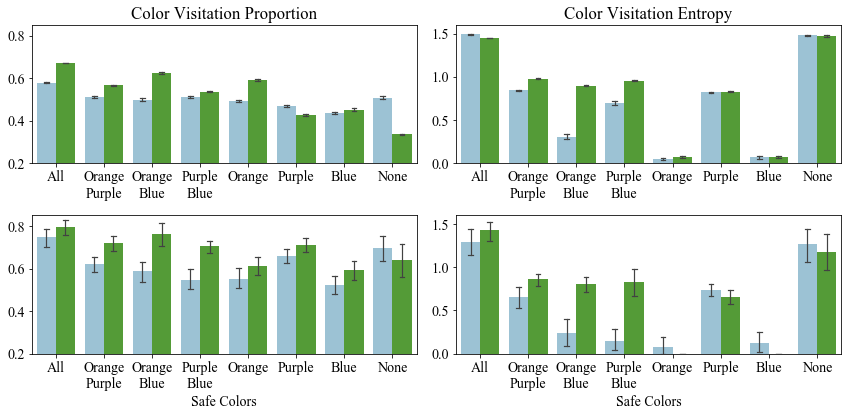

In [288]:
# color visitation proportion and entropy bar plots comparison for simulations and people

from matplotlib import rcParams
rcParams['font.family'] = 'Times New Roman'
rcParams['font.size'] = 14

# dvs = ['dem_len', 'n_revisit', 'uncertain_prop', 'unknown_color_div']
# dvs = ['n_revisit', 'uncertain_prop', 'unknown_color_ent']
dvs = ['uncertain_prop', 'unknown_color_ent']
fig, axes = plt.subplots(2, len(dvs), figsize=(len(dvs)*6, 2*3))
ylims = {
    'dem_len': (5, None),
    'uncertain_prop': (.2, .85),
    "unknown_color_ent": (0.0, 1.6)
}
longdv = {
    'uncertain_prop': "Color Visitation Proportion",
    "unknown_color_ent": "Color Visitation Entropy"
}
mdp_code_names = {
    'ooo': "All",
    'oox': "Orange\nPurple",
    'oxo': "Orange\nBlue",
    "xoo": "Purple\nBlue",
    "oxx": "Orange",
    "xox": "Purple",
    "xxo": "Blue",
    "xxx": "None"
}
sim_traj_stats['safeColors'] = sim_traj_stats['mdp_code'].apply(lambda x: mdp_code_names[x])
exp_traj_stats['safeColors'] = exp_traj_stats['mdp_code'].apply(lambda x: mdp_code_names[x])
safeColor_order = ["All", "Orange\nPurple", "Orange\nBlue", "Purple\nBlue", "Orange", "Purple", "Blue", "None"]
for dvi, dv in enumerate(dvs):
    sns.barplot(data=sim_traj_stats, x='safeColors', y=dv, hue='cond', ax=axes[0][dvi], 
                order=safeColor_order, palette=["#92C5DE", "#4DAC26"], hue_order=['do', 'show'], errwidth=1.2, capsize=.1)
    sns.barplot(data=exp_traj_stats, x='safeColors', y=dv, hue='cond', ax=axes[1][dvi], 
                order=safeColor_order, palette=["#92C5DE", "#4DAC26"], hue_order=['do', 'show'], errwidth=1.2, capsize=.1)
    axes[0][dvi].set_ylim(*ylims.get(dv, (None, None)))
    axes[1][dvi].set_ylim(*ylims.get(dv, (None, None)))
    axes[0][dvi].get_legend().remove()
    axes[1][dvi].get_legend().remove()
    axes[0][dvi].set_xlabel("")
    axes[1][dvi].set_xlabel("Safe Colors")
    axes[0][dvi].set_ylabel("")
    axes[1][dvi].set_ylabel("")
    axes[0][dvi].set_title(longdv[dv])
plt.tight_layout() 

# Compare mean exp/sim belief effects by condition and item

In [12]:
exp_btargs = exp_traj_stats.groupby(['cond', 'mdp_code'])[
    ['final_btarg', 'final_b2targ', 'final_b2jtarg']].mean().reset_index()
sim_btargs = sim_traj_stats.groupby(['belief-reward', 'mdp_code'])[
    ['final_btarg', 'final_b2targ', 'final_b2jtarg']].mean().reset_index()
sim_btargs = sim_btargs.rename(columns={'belief-reward': 'cond'})
sim_btargs['cond'] = sim_btargs['cond'].apply(lambda c: {0:'do', 10:'show'}[c])
expsim_btargs = exp_btargs.merge(sim_btargs, on=['cond', 'mdp_code'],
                                 suffixes=['_exp', '_sim'])

(0, 1.05)

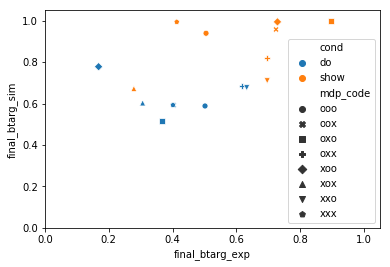

In [13]:
rc('text', usetex=False)
g = sns.scatterplot(data=expsim_btargs,
                x='final_btarg_exp',
                y='final_btarg_sim',
                hue='cond',
                style='mdp_code')
g.set_xlim(0, 1.05)
g.set_ylim(0, 1.05)
# g.legend_.remove()

# Save mean model tile entropy with exp tile entropy

In [14]:
#get mean model statistics by condition and rf
sim_traj_stats_mean = \
    sim_traj_stats.groupby(['mdp_code', 'belief-reward'])[[
        'uncertain_prop', 'unknown_color_ent', 'dem_len', 'avg_revisit'
    ]].mean().reset_index()

exp_traj_stats['belief-reward'] = \
    exp_traj_stats['cond'].apply(lambda c: {'show': 10, 'do':0}[c])

    
exp_meansim_traj_stats = \
    exp_traj_stats[['participant','mdp_code', 'cond', 
                    'belief-reward', 'unknown_color_ent', 
                    'avg_revisit', 'uncertain_prop', 'dem_len']].\
    merge(sim_traj_stats_mean, on=['mdp_code', 'belief-reward'],
          suffixes=('_exp', '_sim'))
exp_meansim_traj_stats.to_csv("./_comps/full_beh_mod.csv", index=False)
# exp_meansim_traj_stats.to_csv("./_comps/exp_meansim_traj_stats.csv", index=False)


# Save mean model color visitation with exp tile color visitation

In [15]:
#load trial-by-trial statistics (without observer beliefs)
exp_trials = pd.read_pickle("../data/exp1-trials.pd.pkl")
exp_trials = exp_trials[exp_trials['phase'] == 'demonstration']
exp_trials['state'] = exp_trials['stateaction'].apply(lambda sa: sa[0])

In [16]:
sim_color_visit = sim_traj_stats_mean[['mdp_code', 'belief-reward', 'uncertain_prop']].reset_index()
sim_color_visit['belief-reward'] = sim_color_visit['belief-reward'].\
    apply(lambda r: {10:'show', 0:'do'}[r])
sim_color_visit = sim_color_visit.\
    rename(columns={'mdp_code': 'rf', 'belief-reward': 'cond', 'uncertain_prop': 'model_uncertain_prop'})
sim_color_visit = exp_trials[['participant', 'cond', 'rf', 'color_tile']]\
    .merge(sim_color_visit, on=['rf', 'cond'])
sim_color_visit.to_csv("./_comps/mod_color_visit.csv", index=False)

## Entropy Plot

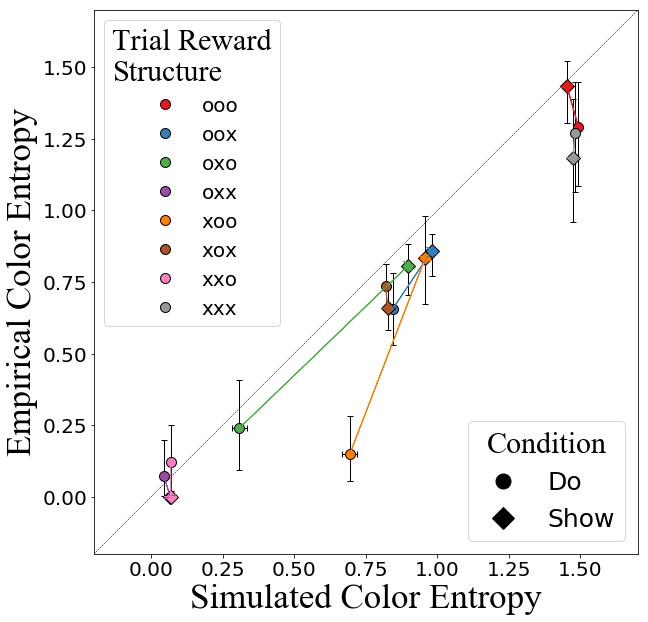

In [17]:
from sklearn.utils import resample

def confint(col, resamples=1000, ci=95):
    bootmeans = [resample(col).mean() for r in range(resamples)]
    lower = np.percentile(bootmeans, (100-ci)/2)
    upper = np.percentile(bootmeans, ci+(100-ci)/2)
    mean = np.mean(bootmeans)
    return (mean - lower, upper - mean)

#set up dataframe
sim_entropy = \
    sim_traj_stats.groupby(["belief-reward", "mdp_code"])\
        ["unknown_color_ent"].aggregate(["mean", confint]).reset_index()
sim_entropy = sim_entropy.rename(columns={
    "belief-reward": "cond",
#     "mdp_code": "rf",
    "unknown_color_ent": "color_visit_entropy"
})
sim_entropy['cond'] = sim_entropy['cond'].apply(
    lambda r: {10:'show', 0:'do'}[r])
exp_entropy = exp_traj_stats.groupby(["cond", "mdp_code"])\
        ["unknown_color_ent"].aggregate(["mean", confint]).reset_index()
expmod_entropy = sim_entropy.merge(
    exp_entropy, on=['cond', 'mdp_code'], 
    suffixes=('_mod', '_exp'))
expmod_entropy = expmod_entropy.pivot(index='mdp_code', columns='cond')
expmod_entropy.columns = \
    ['_'.join(col).strip() for col in expmod_entropy.columns.values]
    
#plot
import matplotlib.colors as colors
import matplotlib.cm as cmx

colorrange = plt.get_cmap('Set1')
color_norm = colors.Normalize(vmin=0, vmax=9)
value_map = cmx.ScalarMappable(norm=color_norm, cmap=colorrange)
legend_ele = []
legend_labels = []

fig, ax = plt.subplots(1,1, figsize=(10, 10))
ci = 0
for rf, row in expmod_entropy.iterrows():
    rf_color = value_map.to_rgba(ci)
    y0, x0 = row['mean_exp_do'], row['mean_mod_do']
    y1, x1 = row['mean_exp_show'], row['mean_mod_show']
    ax.annotate('', xy=(x1, y1), xytext=(x0, y0),
                xycoords='data', textcoords='data',
                arrowprops=dict(
#                     arrowstyle="-",
                    color=rf_color,
                    headlength=.1,
                    width=.3,
                                connectionstyle="arc3"),
               )
    ele = plt.errorbar(
                 row['mean_mod_do'], row['mean_exp_do'],
                 np.array([row['confint_exp_do'],]).T, 
                 np.array([row['confint_mod_do'],]).T,
                 capsize=3, capthick=1, elinewidth=1, fmt='o',
                 ecolor='k', color=rf_color,
                 barsabove=False, ms=10, mec='k')
    legend_ele.append(ele[0])
    legend_labels.append(rf)
    plt.errorbar(row['mean_mod_show'], row['mean_exp_show'],
                 np.array([row['confint_exp_show'],]).T,
                 np.array([row['confint_mod_show'],]).T,
                 capsize=3, capthick=1, elinewidth=1, fmt='D',
                 ecolor='k', color=value_map.to_rgba(ci),
                 barsabove=False, ms=10, mec='k')
    if ci == 4: #skip yellow
        ci += 1
    ci += 1
# plt.plot([0, 2], [-0.07524, -0.07524+2*0.92210])
# plt.plot([-1, 2], [-0.07524+(-1*0.92210), -0.07524+2*0.92210],
#          '--k', linewidth=.5)
plt.plot([-1, 2], [-1, 2], '--k', linewidth=.5)
plt.xlim(-.2, 1.7)
plt.ylim(-.2, 1.7)
ax.set_aspect('equal', 'box')
legend0 = plt.legend(legend_ele, legend_labels, fontsize=20, 
                    title='Trial Reward\nStructure')
plt.setp(legend0.get_title(),fontsize=30, fontname="Times New Roman")
plt.ylabel('Empirical Color Entropy', fontsize=35, fontname="Times New Roman")
plt.xlabel('Simulated Color Entropy', fontsize=35, fontname="Times New Roman")
_ = plt.setp(ax.get_xticklabels(), fontsize=20)
_ = plt.setp(ax.get_yticklabels(), fontsize=20)

import matplotlib.lines as mlines

black_circle = mlines.Line2D([], [], color='black', marker='o', linestyle='None',
                             markersize=15, label='Do')
black_diamond = mlines.Line2D([], [], color='black', marker='D', linestyle='None',
                             markersize=15, label='Show')

legend1 = plt.legend(handles=[black_circle, black_diamond], fontsize=25, 
                     title='Condition', loc=4)
plt.setp(legend1.get_title(),fontsize=30, fontname="Times New Roman")
plt.gca().add_artist(legend0)
plt.savefig('./_figures/exp1-entropy-qq.eps')

## Comparison of Model-Model and Human-Human Learning

In [18]:
exp1L_trials = pd.read_pickle("../data/exp1L-trials.pd.pkl")

In [19]:
mod_rounds_mean = sim_traj_stats.groupby(['belief-reward', 'mdp_code'])\
    [['b_orange_cor', 'b_purple_cor',
        'b_blue_cor', 'b2_orange_cor', 'b2_purple_cor', 'b2_blue_cor',
        'b2j_orange_cor', 'b2j_purple_cor', 'b2j_blue_cor']]\
    .mean().reset_index()
mod_rounds_mean = mod_rounds_mean.rename(columns={
    'belief-reward': 'teacher_inst', 
    'mdp_code': 'rf'
})
mod_rounds_mean['teacher_inst'] = \
    mod_rounds_mean['teacher_inst'].apply(
        lambda r: {0:'doing', 10:'showing'}[r])
expmod_rounds = \
    exp1L_trials.merge(mod_rounds_mean, on=['teacher_inst', 'rf'])
    
def get_model_preds(row):
    if row['learner_inst'] == 'doing':
        obs_type_pred = row['b_'+row['color']+'_cor']
    elif row['learner_inst'] == 'showing':
        obs_type_pred = row['b2_'+row['color']+'_cor']
        
    return pd.Series({
        'obs_type_pred': obs_type_pred,
        'b_pred': row['b_'+row['color']+'_cor'],
        'b2_pred': row['b2_'+row['color']+'_cor'],
        'b2j_pred': row['b2j_'+row['color']+'_cor']
    })
mod_preds = expmod_rounds.apply(get_model_preds, axis=1)
expmod_rounds = pd.concat([expmod_rounds, mod_preds], axis=1)
expmod_rounds.to_csv("./_comps/1L-expsim_judg.csv")

expmod_rounds_mean = expmod_rounds.groupby(
    ['teacher_inst', 'learner_inst', 'rf', 'color'])\
    ['correct', 'obs_type_pred', 'b_pred', 'b2_pred', 
     'b2j_pred'].mean().reset_index()

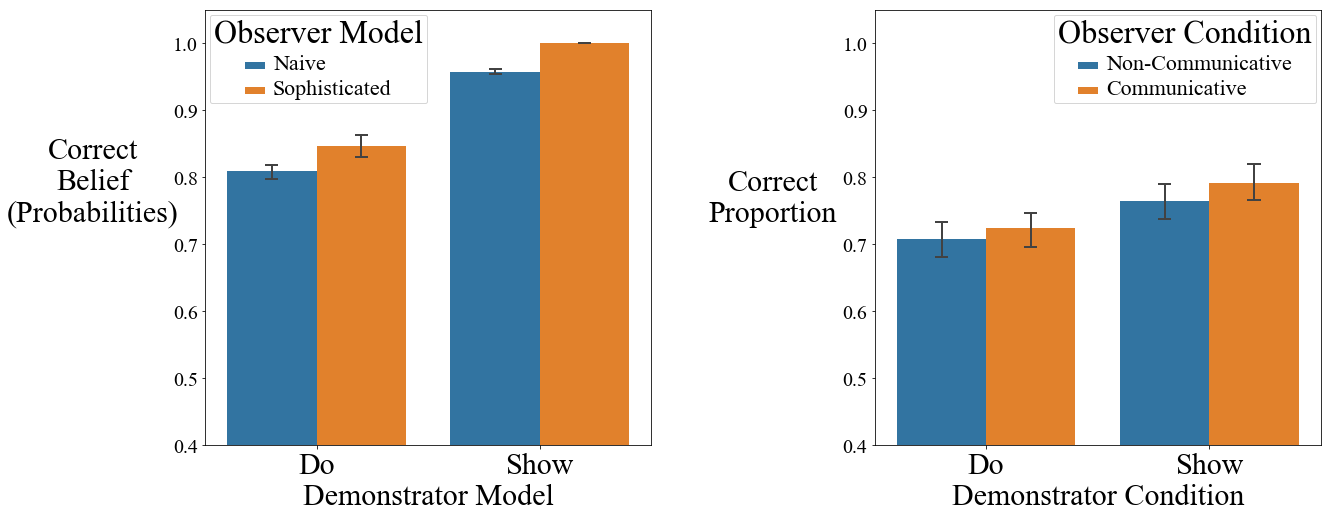

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

g = sns.barplot(ax=ax[0],
            data=expmod_rounds.groupby(['teacher_inst', 'learner_inst', 
                                      'workerid'])['obs_type_pred'].mean().reset_index(), 
            x='teacher_inst',
            ci=95,
            y='obs_type_pred', hue='learner_inst',
            order=['doing', 'showing'],
            hue_order=['doing', 'showing'],
               capsize=.05,
               errwidth=2)
plt.ylim(.4, 1.05)

ax[0].set_ylim(.4, 1.05)
_ = plt.setp(ax[0].get_xticklabels(), fontsize=30, fontname="Times New Roman")
_ = plt.setp(ax[0].get_yticklabels(), fontsize=20, fontname="Times New Roman")
ax[0].set_xticklabels(["Do", "Show"])
ax[0].set_xlabel('Demonstrator Model', fontsize=30, fontname="Times New Roman")
ax[0].set_ylabel('Correct\nBelief\n(Probabilities)', 
                 fontsize=30, fontname="Times New Roman", 
                 rotation='horizontal', ha='center', labelpad=80)
ax[0].get_legend().get_title().set_text("Observer Model")
ax[0].get_legend().get_texts()[0].set_text("Naive")
ax[0].get_legend().get_texts()[1].set_text("Sophisticated")
plt.setp(ax[0].get_legend().get_texts(), fontsize='22', fontname="Times New Roman") # for legend text
plt.setp(ax[0].get_legend().get_title(), fontsize='32', fontname="Times New Roman") # for legend title

g = sns.barplot(ax=ax[1],
                data=expmod_rounds.groupby(['teacher_inst', 'learner_inst', 
                                      'workerid'])['correct'].mean().reset_index(), 
                x='teacher_inst',
                ci=95,
                y='correct', hue='learner_inst',
                order=['doing', 'showing'],
                hue_order=['doing', 'showing'],
               capsize=.05,
               errwidth=2)
ax[1].set_ylim(.4, 1.05)
_ = plt.setp(ax[1].get_xticklabels(), fontsize=30, fontname="Times New Roman")
_ = plt.setp(ax[1].get_yticklabels(), fontsize=20, fontname="Times New Roman")
ax[1].set_xticklabels(["Do", "Show"])
ax[1].set_xlabel('Demonstrator Condition', fontsize=30, fontname="Times New Roman")
ax[1].set_ylabel('Correct\nProportion', fontsize=30, fontname="Times New Roman", 
           rotation='horizontal', ha='center', labelpad=70)
ax[1].get_legend().get_title().set_text("Observer Condition")
ax[1].get_legend().get_texts()[0].set_text("Non-Communicative")
ax[1].get_legend().get_texts()[1].set_text("Communicative")
plt.setp(ax[1].get_legend().get_texts(), fontsize='22', fontname="Times New Roman") # for legend text
plt.setp(ax[1].get_legend().get_title(), fontsize='32', fontname="Times New Roman") # for legend title

plt.subplots_adjust(wspace=.5)
plt.savefig('./_figures/exp1L-correct_cond.eps')

# Comparison of Human-Model and Human-Human learning

In [21]:
exp1L_trials.groupby(['teacher_inst', 'learner_inst'])['correct'].mean()

teacher_inst  learner_inst
doing         doing           0.707615
              showing         0.723420
showing       doing           0.765086
              showing         0.790948
Name: correct, dtype: float64

In [22]:
exp_obsmod_res = exp_traj_stats.melt(
    id_vars=['cond', 'participant', 'mdp_code'],
    value_vars=['b_orange_cor', 'b_purple_cor',
                'b_blue_cor', 'b2_orange_cor', 
                'b2_purple_cor', 'b2_blue_cor'],
    var_name='obs_model-color', value_name='belief')

exp_obsmod_res['obs_model'] = exp_obsmod_res['obs_model-color'].apply(
    lambda x: x.split('_')[0]
)

In [23]:
exp_obsmod_res.to_csv("./_comps/human-teacher-model-observer.csv")

In [24]:
exp_obsmod_res.groupby(['cond', 'obs_model'])['belief'].mean()

cond  obs_model
do    b            0.717062
      b2           0.754142
show  b            0.803463
      b2           0.834050
Name: belief, dtype: float64

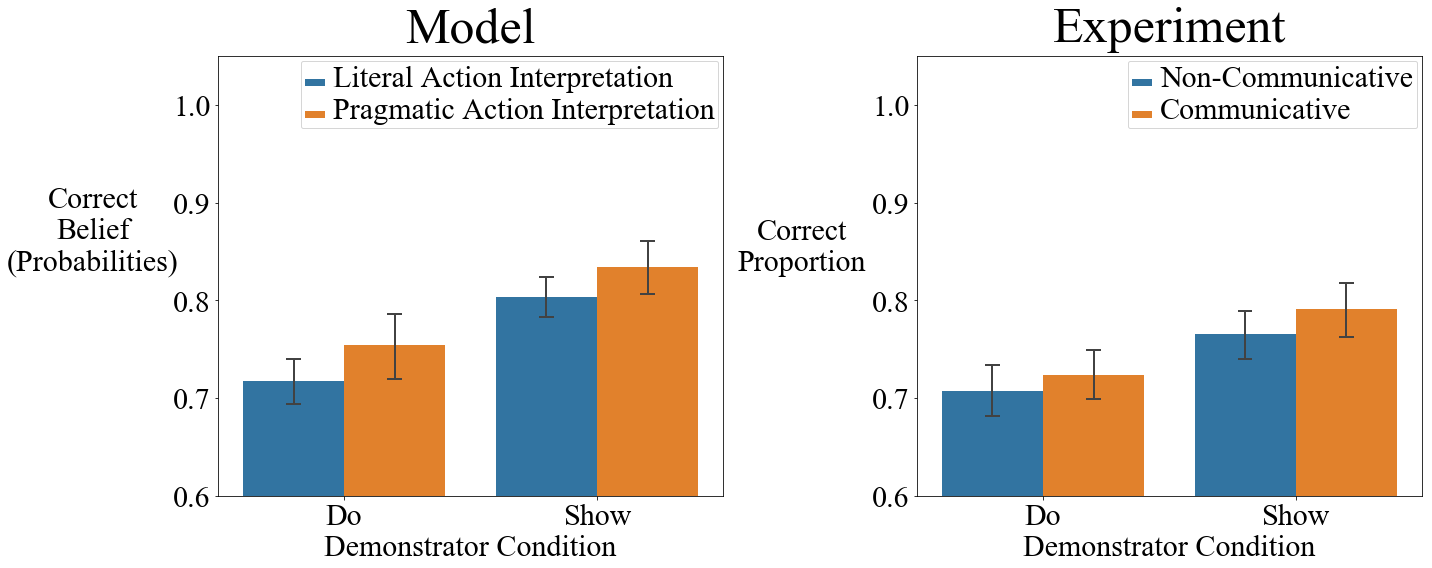

In [26]:
exp_obsmod_res.to_pickle("./_comps/_exp_obsmod_res.df.pkl")
exp_obsmod_res = pd.read_pickle("./_comps/_exp_obsmod_res.df.pkl")
expmod_rounds.to_pickle("./_comps/_expmod_rounds.df.pkl")
expmod_rounds = pd.read_pickle("./_comps/_expmod_rounds.df.pkl")

fig, ax = plt.subplots(1, 2, figsize=(20, 8))

g = sns.barplot(ax=ax[0],
            data=exp_obsmod_res, 
            x='cond',
            ci=95,
            y='belief', hue='obs_model',
            order=['do', 'show'],
            hue_order=['b', 'b2'],
               capsize=.05,
               errwidth=2)
plt.ylim(.4, 1.05)

ax[0].set_ylim(.6, 1.05)
_ = plt.setp(ax[0].get_xticklabels(), fontsize=30, fontname="Times New Roman")
_ = plt.setp(ax[0].get_yticklabels(), fontsize=30, fontname="Times New Roman")
ax[0].set_xticklabels(["Do", "Show"])
ax[0].set_xlabel('Demonstrator Condition', fontsize=30, fontname="Times New Roman")
ax[0].set_ylabel('Correct\nBelief\n(Probabilities)', 
                 fontsize=30, fontname="Times New Roman", 
                 rotation='horizontal', ha='center', labelpad=80)

# ax[0].get_legend().get_title().set_text("")

handles, labels = ax[0].get_legend_handles_labels()
ax[0].legend(handles=handles, labels=labels)

ax[0].get_legend().get_texts()[0].set_text("Literal Action Interpretation")
ax[0].get_legend().get_texts()[1].set_text("Pragmatic Action Interpretation")
plt.setp(ax[0].get_legend().get_texts(), fontsize='30', fontname="Times New Roman") # for legend text
# plt.setp(ax[0].get_legend().get_title(), fontsize='32', fontname="Times New Roman") # for legend title
tit = ax[0].set_title("Model", fontsize=50, fontname="Times New Roman")
tit.set_position([.5, 1.02])

g = sns.barplot(ax=ax[1],
                data=expmod_rounds.groupby(['teacher_inst', 'learner_inst', 
                                      'workerid'])['correct'].mean().reset_index(), 
                x='teacher_inst',
                ci=95,
                y='correct', hue='learner_inst',
                order=['doing', 'showing'],
                hue_order=['doing', 'showing'],
               capsize=.05,
               errwidth=2)
ax[1].set_ylim(.6, 1.05)
_ = plt.setp(ax[1].get_xticklabels(), fontsize=30, fontname="Times New Roman")
_ = plt.setp(ax[1].get_yticklabels(), fontsize=30, fontname="Times New Roman")
ax[1].set_xticklabels(["Do", "Show"])
ax[1].set_xlabel('Demonstrator Condition', fontsize=30, fontname="Times New Roman")
ax[1].set_ylabel('Correct\nProportion', fontsize=30, fontname="Times New Roman", 
           rotation='horizontal', ha='center', labelpad=70)
# ax[1].get_legend().get_title().set_text("Observer Condition")
handles, labels = ax[1].get_legend_handles_labels()
ax[1].legend(handles=handles, labels=labels)

ax[1].get_legend().get_texts()[0].set_text("Non-Communicative")
ax[1].get_legend().get_texts()[1].set_text("Communicative")
plt.setp(ax[1].get_legend().get_texts(), fontsize='30', fontname="Times New Roman") # for legend text
# plt.setp(ax[1].get_legend().get_title(), fontsize='32', fontname="Times New Roman") # for legend title
tit = ax[1].set_title("Experiment", fontsize=50, fontname="Times New Roman")
tit.set_position([.5, 1.02])

plt.subplots_adjust(wspace=.5)
plt.tight_layout()
plt.savefig('./_figures/exp1L-correct_cond.eps')

### Do model simulation quantities predict behavior quantities?

In [23]:
%%R

library(lmerTest)

traj_stats <- read.csv("./_comps/full_beh_mod.csv")

entmodel <- lmer(
  unknown_color_ent_exp ~ unknown_color_ent_sim
      + (1 + unknown_color_ent_sim | participant) + (1 | mdp_code),
  data = traj_stats,
  control=lmerControl(optimizer="bobyqa",
                       optCtrl=list(maxfun=3e5))
)

mod_color_visit <- read.csv('./_comps/mod_color_visit.csv')
mod_color_visit$color_tile = mod_color_visit$color_tile == 'True'

colorvisit_mod <- glmer(
  color_tile ~ model_uncertain_prop + (1 | participant) + (1 + model_uncertain_prop | rf),
  data = mod_color_visit,
  family=binomial,
  control=glmerControl(optimizer="bobyqa",
                       optCtrl=list(maxfun=3e5))
)


In [24]:
print(ro.r("summary(entmodel)"))

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: 
unknown_color_ent_exp ~ unknown_color_ent_sim + (1 + unknown_color_ent_sim |  
    participant) + (1 | mdp_code)
   Data: traj_stats
Control: lmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 3e+05))

REML criterion at convergence: 351.5

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.4954 -0.2590  0.0199  0.3315  3.6097 

Random effects:
 Groups      Name                  Variance Std.Dev. Corr 
 participant (Intercept)           0.019252 0.13875       
             unknown_color_ent_sim 0.060169 0.24529  -0.68
 mdp_code    (Intercept)           0.009262 0.09624       
 Residual                          0.097711 0.31259       
Number of obs: 464, groups:  participant, 58; mdp_code, 8

Fixed effects:
                      Estimate Std. Error       df t value Pr(>|t|)    
(Intercept)           -0.09875    0.06468  7.68134  -1.527    0.167    
unknown_color_ent_sim  0.9

In [26]:
print(ro.r("summary(colorvisit_mod)"))

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: color_tile ~ model_uncertain_prop + (1 | participant) + (1 +  
    model_uncertain_prop | rf)
   Data: mod_color_visit
Control: glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 3e+05))

     AIC      BIC   logLik deviance df.resid 
  5471.3   5509.6  -2729.7   5459.3     4368 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.6438 -1.1264  0.5647  0.7440  1.4130 

Random effects:
 Groups      Name                 Variance Std.Dev. Corr 
 participant (Intercept)          0.09109  0.3018        
 rf          (Intercept)          2.58768  1.6086        
             model_uncertain_prop 9.65137  3.1067   -1.00
Number of obs: 4374, groups:  participant, 58; rf, 8

Fixed effects:
                     Estimate Std. Error z value Pr(>|z|)   
(Intercept)           -1.5781     0.7953  -1.984  0.04722 * 
model_uncertain_prop   4.1807     1.48